[](http://)

In [1]:
import math
from typing import List, Optional, Tuple, Union
import sys
from PIL import Image
from pathlib import Path
import torch
import os
import cv2
from accelerate import Accelerator
from torch import nn
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
    AutoConfig,
)
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Any, Dict, Generator, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
import pandas as pd

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")
from transformers import ViTFeatureExtractor, ViTModel
import itertools

2024-05-23 17:42:00.226905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 17:42:00.227012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 17:42:00.371329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [3]:
from einops import rearrange, reduce, repeat


class AttentionSelfOutput(nn.Module):
    def __init__(self, config, bias: Optional[bool] = True):
        super().__init__()
        self.dense = nn.Linear(
            config.hidden_size,
            config.hidden_size,
            bias=bias,
        )
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, hidden_states: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layernorm(hidden_states + input_tensor)
        return hidden_states


class EncoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.q = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.k = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.v = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        q = self.q(hidden_state)
        k = self.k(hidden_state)
        v = self.v(hidden_state)
        # q,k,v = self.qkv(hidden_state).chunk(3, dim = -1) #b X l X d dim =-1 or 2
        # place holder for RoPe operation
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask, is_causal=False
        )
        out = rearrange(out, "b h l d -> b l (h d)")
        out = self.out(out, hidden_state)
        return out


class AbsoluteEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.pos_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )
        self.max_size = config.max_position_embeddings

    def forward(self, size: int) -> torch.Tensor:
        if self.max_size < size:
            raise ValueError(
                f"The hidden size ({size }) is more than the config max_position_embeddings {self.max_size}"
            )
        return self.pos_embeddings(self.position_ids[:, :size])


class SinusoidalEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config.hidden_size % 2 != 0:
            raise ValueError(
                f"Cannot use SinusoidalEncoding with "
                "odd hidden dim got dim {config.hidden_size}"
            )
        self.positional_encoding = torch.zeros(
            1, config.max_position_embeddings, config.hidden_size
        )
        self.position = torch.arange(0, config.max_position_embeddings).unsqueeze(1)
        self.div_term = torch.exp(
            (
                torch.arange(0, config.hidden_size, 2, dtype=torch.float)
                * -(torch.log(torch.tensor(10000.0)) / config.hidden_size)
            )
        )

        self.positional_encoding[:, :, 0::2] = torch.sin(
            self.position.float() * self.div_term
        )
        self.positional_encoding[:, :, 1::2] = torch.cos(
            self.position.float() * self.div_term
        )

    def forward(self, seq_len: int) -> torch.Tensor:

        return self.positional_encoding[:, :seq_len]


# copied from transformer/models/gemma
class RotaryEmbedding(nn.Module):
    def __init__(self, config, base=10000, device=None):
        super().__init__()

        self.dim = int(config.hidden_size // config.num_attention_heads)
        self.max_position_embeddings = config.max_position_embeddings
        self.base = base
        self.register_buffer(
            "inv_freq",
            1.0
            / (
                self.base
                ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim)
            ),
            persistent=False,
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )

    @torch.no_grad()
    def forward(self, seq_len: int = None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # size = x.size()[2]
        position_ids = torch.arange(seq_len).unsqueeze(0)
        # position_ids = self.position_ids[:, :size].float()

        inv_freq_expanded = (
            self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        )
        position_ids_expanded = position_ids[:, None, :].float()

        freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(
            1, 2
        )
        return freqs


# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


# def rotate_half(x):
#     x1, x2 = x.chunk(2, dim=-1)
#     return torch.cat((-x2, x1), dim=-1)


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, freqs, unsqueeze_dim=1) -> Tuple[torch.Tensor]:
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        freqs: precalculated frqs for sin cos
        only_q: bool = False for encoder decoder
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    emb = torch.cat((freqs, freqs), dim=-1)
    cos = emb.cos().to(dtype=q.dtype)
    sin = emb.sin().to(dtype=q.dtype)
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [4]:
_ACT_ = {
    "gelu": nn.GELU(),
    "leaky_relu": nn.LeakyReLU(),
    "relu6": nn.ReLU6(),
    "sigmoid": nn.Sigmoid(),
    "silu": nn.SiLU(),
    "swish": nn.SiLU(),
    "tanh": nn.Tanh(),
}


class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        self.intermediate = nn.Linear(
            config.hidden_size, int(multiplier) * config.hidden_size
        )
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        if _ACT_.get(getattr(config, "hidden_act", None), None):
            self.act_fn = _ACT_[config.hidden_act]
        else:
            self.act_fn = nn.GELU()
        self.out = nn.Linear(int(multiplier) * config.hidden_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layerNorm(output + input_tensor)
        return output


import torch
import torch.nn as nn
from typing import Optional, Tuple

from dataclasses import dataclass

_position_embeddings = {
    "absolute": AbsoluteEncoding,
    "sinusoidal": SinusoidalEncoding,
}


@dataclass
class EncoderOutput(object):
    logits: torch.Tensor


class EncoderLayer(nn.Module):
    def __init__(self, config, layer_idx: int, attention_type: str = None) -> None:
        super().__init__()
        self.attention = EncoderAttention(config, layer_idx=layer_idx)
        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: torch.Tensor = None,
    ) -> torch.Tensor:
        out = self.attention(
            hidden_state=hidden_state, attention_mask=attention_mask, freqs=freqs
        )
        out = self.feed_forward(out, hidden_state)
        return out


class EncoderModel(nn.Module):

    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        if _position_embeddings.get(pos_embedding_type, None) is not None:
            self.position_embeddings = _position_embeddings.get(pos_embedding_type)(
                config
            )
        else:
            self.position_embeddings = None
        if pos_embedding_type == "rope":
            self.emb_freq = RotaryEmbedding(config)(config.max_position_embeddings)
            print(
                "Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable"
            )
        self.all_layer = nn.ModuleList(
            [
                EncoderLayer(config, layer_idx, attention_type)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        bsz, seqlen = input_ids.shape
        hidden_state = self.word_embeddings(input_ids)
        freqs = None
        if self.position_embeddings is not None:
            pos_info = self.position_embeddings(seqlen)[:, :seqlen, :].to(
                input_ids.device
            )
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, :seqlen].to(input_ids.device)

        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).type_as(hidden_state)
        attention_mask = (1.0 - attention_mask) * torch.finfo(hidden_state.dtype).min

        for layer in self.all_layer:
            hidden_state = layer(hidden_state, attention_mask, freqs)
        return EncoderOutput(hidden_state)

    @classmethod
    def from_config(
        cls,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> nn.Module:
        return cls(config, pos_embedding_type, attention_type)

In [5]:
model_ckpt = "FacebookAI/roberta-base"
encoder_ = AutoModel.from_pretrained(model_ckpt)

config = AutoConfig.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
encoder = EncoderModel(config, pos_embedding_type="rope")

Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable


In [7]:
encoder.word_embeddings.weight = encoder_.embeddings.word_embeddings.weight
del encoder_

In [8]:
vit_encoder = ViTModel.from_pretrained("WinKawaks/vit-small-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://arxiv.org/abs/2103.00020

*paper link*
https://arxiv.org/abs/2103.00020

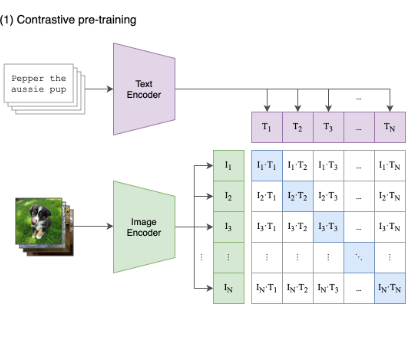

Let's consider what we hope that this model learns: we want it to learn "similar representations (vectors)" for a given image and the caption describing it. Meaning that either we give it an image or the text describing it, we want it to produce same 256 sized vectors for both

In [9]:
def cross_entropy(preds, targets, reduction="none"):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


def clip_loss(image_embeddings, text_embeddings, temperature=2):
    # Calculating the Loss
    logits = (text_embeddings @ image_embeddings.T) / temperature  # image Vs Text
    images_similarity = image_embeddings @ image_embeddings.T  # image Vs image
    texts_similarity = text_embeddings @ text_embeddings.T  # Text Vs Text
    targets = F.softmax((images_similarity + texts_similarity) / temperature, dim=-1)
    texts_loss = cross_entropy(logits, targets, reduction="none")
    images_loss = cross_entropy(logits.T, targets.T, reduction="none")
    loss = (images_loss + texts_loss) / 2.0  # shape: (batch_size)
    return loss.mean()


class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        projection_dim = 256
        dropout = 0.15
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x


class ClipModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_model = vit_encoder
        self.text_model = encoder
        self.text_proj = ProjectionHead()
        self.image_proj = ProjectionHead(384)

    def forward(
        self,
        pixel_values: Optional[torch.LongTensor] = None,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
    ):
        image_embd = self.image_model(pixel_values=pixel_values).pooler_output
        image_embd = self.image_proj(image_embd)
        text_embd = self.text_model(input_ids, attention_mask).logits[:, 0, :]
        text_embd = self.text_proj(text_embd)
        return image_embd, text_embd

    def get_image_embd(self, pixel_values):
        image_embd = self.image_model(pixel_values=pixel_values).pooler_output
        image_embd = self.image_proj(image_embd)
        return image_embd

    def get_text_embd(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
    ):
        text_embd = self.text_model(input_ids, attention_mask).logits[:, 0, :]
        text_embd = self.text_proj(text_embd)
        return text_embd

In [10]:
clip_model = ClipModel()

In [11]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50

    def __len__(
        self,
    ):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")

        #         if self.transform is not None:
        #             img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        text = self.tokenizer(
            caption, padding="max_length", max_length=self.max_length, truncation=True
        )
        captions = text.input_ids
        #         captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "input_ids": torch.tensor(captions),
            "attention_mask": torch.tensor(text.attention_mask),
        }
        return encoding

**Using pretrained image encoder for faster convergence you can also use your own image encoder see vit tutorial**

In [12]:
feature_extractor = ViTFeatureExtractor.from_pretrained(
    "WinKawaks/vit-small-patch16-224"
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [13]:
# df=  pd.read_csv("../input/flickr30k/captions.txt")
# df = df.dropna()
# df.shape

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
df = pd.read_csv(
    "../input/flickr-image-dataset/flickr30k_images/results.csv", delimiter="|"
)
df.columns = ["image", "caption_number", "caption"]
df["caption"] = df["caption"].str.lstrip()
df["caption_number"] = df["caption_number"].str.lstrip()
ids = [id_ for id_ in range(len(df) // 5) for i in range(5)]
df["id"] = ids
#
df.head()

image caption_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             caption  id  
0  Two young guys with shaggy hair look at their ...   0  
1  Two young , White males are outside near many ...   0  
2   Two men in green shirts are standing in a yard .   0  
3       A man in a blue shirt standing in a garden .   0  
4            Two friends enjoy time spent together .   0

In [16]:
df[df["caption"].isnull()]

image                     caption_number caption    id
19999  2199200615.jpg  4   A dog runs across the grass .     NaN  3999

In [17]:
df.loc[19999, "caption_number"] = "4"
df.loc[19999, "caption"] = "A dog runs across the grass ."
df.isna().sum()

image             0
caption_number    0
caption           0
id                0
dtype: int64

In [18]:
# df = df.sample(frac=0.2, random_state=42)
# # dff.shape
train_df, val_df = train_test_split(df, test_size=0.15)
# df.head()
train_dataset = ImgDataset(
    train_df,
    root_dir="../input/flickr-image-dataset/flickr30k_images/flickr30k_images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
)
val_dataset = ImgDataset(
    val_df,
    root_dir="../input/flickr-image-dataset/flickr30k_images/flickr30k_images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [19]:
def validation(model, val_loader=val_loader):
    model.eval()
    all_loss = 0.0
    for step, data in tqdm(enumerate(val_loader)):
        input_ids = data["input_ids"]
        pixel_values = data["pixel_values"].to(device)
        with torch.no_grad():
            image_embd, text_embd = model(
                pixel_values=pixel_values,
                input_ids=input_ids.to(device),
                attention_mask=data["attention_mask"].to(device),
            )
        loss = clip_loss(image_embd, text_embd)
        all_loss += loss.detach().cpu().item()
    print("validation_loss = ", all_loss / len(val_loader))
    return all_loss / len(val_loader)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def single_gpu():
    accumulation_steps = 1  # batch size 64 large dont need gradient accumulation

    EPOCHS = 3

    accelerator = Accelerator(
        log_with="tensorboard",
        project_dir=".",
    )
    accelerator.init_trackers("clip_project")
    no_decay = ["bias", "layernorm.weight", "layernorm.bias"]
    params = [
        {"params": clip_model.image_model.parameters(), "lr": 5e-5},
        {"params": clip_model.text_model.parameters(), "lr": 5e-5},
        {
            "params": itertools.chain(
                clip_model.text_proj.parameters(), clip_model.image_proj.parameters()
            ),
            "lr": 5e-5,
            "weight_decay": 5e-5,
        },
    ]

    optimizer = torch.optim.AdamW(params, weight_decay=0.0)
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    #     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.05 * num_train_optimization_steps,
    #                                     num_training_steps=num_train_optimization_steps)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.8
    )
    clip_model.to(device)

    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    t_step = 1
    k = 0
    for epoch in range(EPOCHS):
        clip_model.train()
        avg_loss = 0.0
        loss_list = []
        running_loss = 0.0
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            input_ids = data["input_ids"]
            pixel_values = data["pixel_values"].to(device)
            optimizer.zero_grad()
            image_embd, text_embd = clip_model(
                pixel_values=pixel_values,
                input_ids=input_ids.to(device),
                attention_mask=data["attention_mask"].to(device),
            )
            loss = clip_loss(image_embd, text_embd)
            loss.backward()
            optimizer.step()
            #             scheduler.step()

            accelerator.log({"training_loss_step": loss}, step=t_step)

            train_bar.set_description(
                f'epoch: {epoch+1} step: {t_step} loss: {"%.4f" % loss}'
            )
            t_step += 1
            loss_list.append(loss.detach().cpu().item())
        #         scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"training_loss_epoch": avg_loss}, step=epoch + 1)
        print(f'Epoch: {epoch+1} loss: {"%.4f" % avg_loss }')
        vloss = validation(clip_model)
        lr_scheduler.step(vloss)
    accelerator.end_training()
    PATH = f"vit_clip_{epoch}.pth"
    torch.save(clip_model.state_dict(), PATH)

In [21]:
single_gpu()

  0%|          | 0/6333 [00:00<?, ?it/s]

Epoch: 1 loss: 1.5820


0it [00:00, ?it/s]

validation_loss =  0.6964494789733324
Epoch: 2 loss: 0.5433


0it [00:00, ?it/s]

validation_loss =  0.5341847716723307
Epoch: 3 loss: 0.3703


0it [00:00, ?it/s]

validation_loss =  0.464812082355847


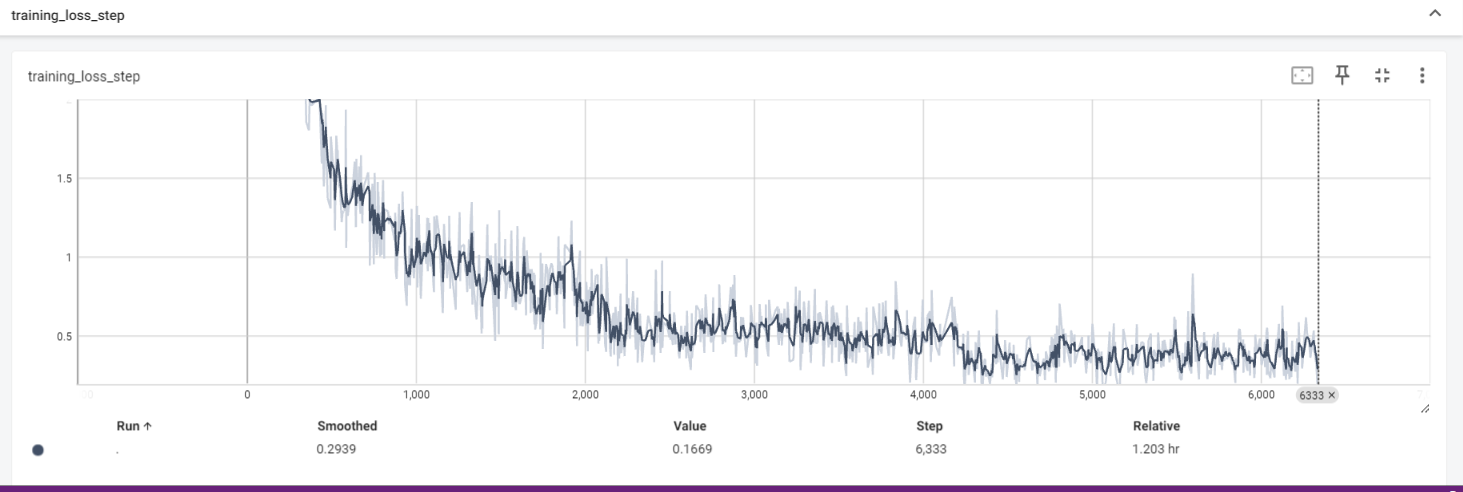

In [22]:
clip_model.eval()

ClipModel(
  (image_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_

In [23]:
def get_image_embeddings(clip_model, valid_loader, tokenizer):

    clip_model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_embeddings = clip_model.get_image_embd(
                batch["pixel_values"].to(device)
            )

            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)


image_embeddings = get_image_embeddings(clip_model, val_loader, tokenizer)


def find_matches(clip_model, image_embeddings, query, tokenizer, image_filenames, n=6):
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device) for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = clip_model.get_text_embd(
            batch["input_ids"], batch["attention_mask"]
        )
    #         text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(2, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(
            f"{'../input/flickr-image-dataset/flickr30k_images/flickr30k_images'}/{match}"
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

  0%|          | 0/373 [00:00<?, ?it/s]

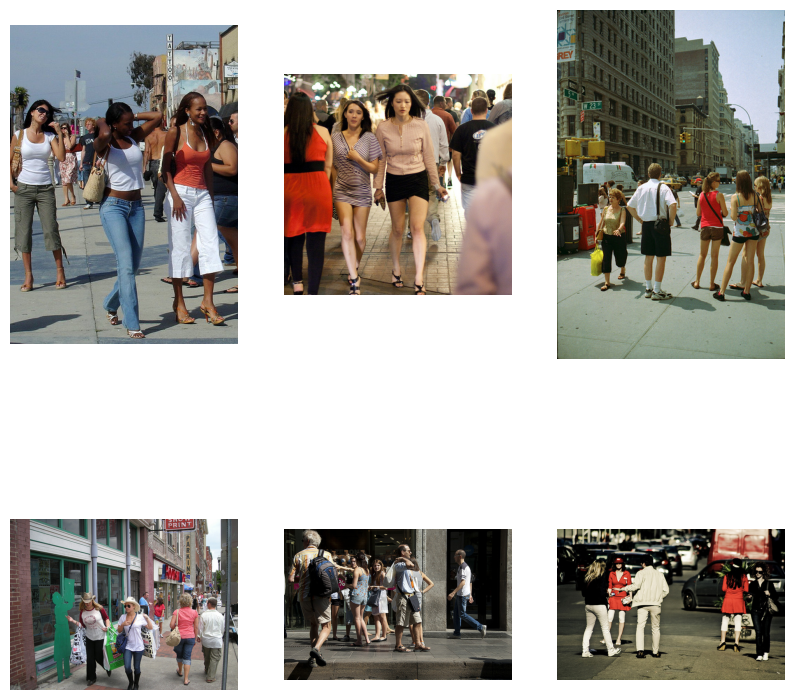

In [24]:
find_matches(
    clip_model,
    image_embeddings,
    query="A group of ladies walking along a sidewalk",
    tokenizer=tokenizer,
    image_filenames=val_df["image"].values,
    n=6,
)

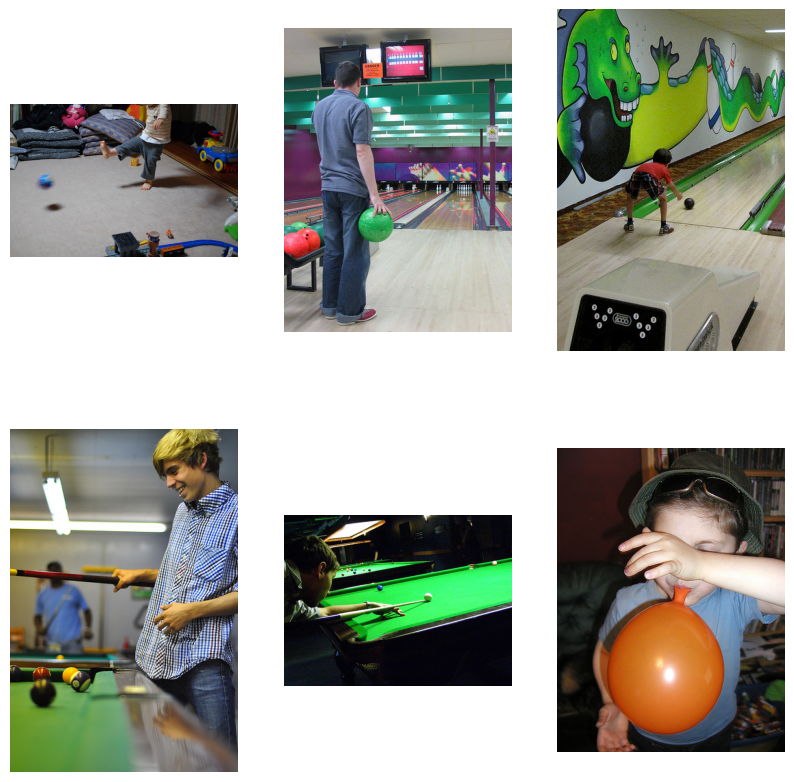

In [25]:
find_matches(
    clip_model,
    image_embeddings,
    query="A boy is playing in a room full of balls",
    tokenizer=tokenizer,
    image_filenames=val_df["image"].values,
    n=6,
)

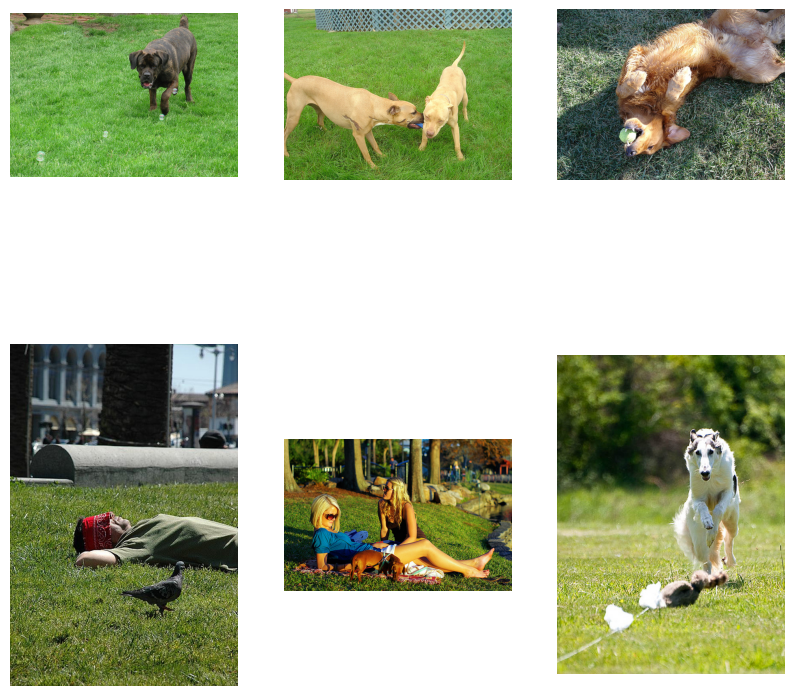

In [26]:
find_matches(
    clip_model,
    image_embeddings,
    query="dogs sitting on the grass",
    tokenizer=tokenizer,
    image_filenames=val_df["image"].values,
    n=6,
)

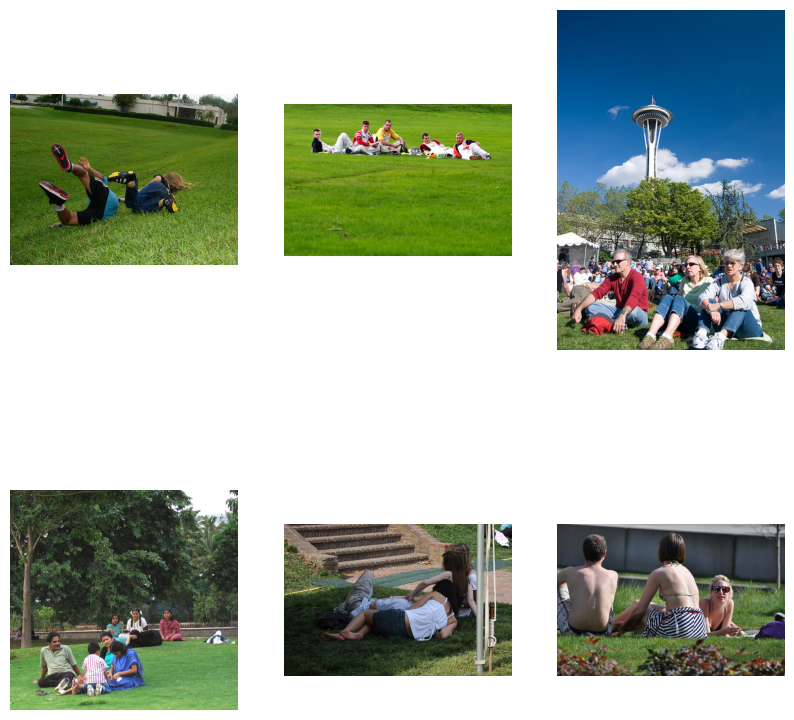

In [27]:
find_matches(
    clip_model,
    image_embeddings,
    query="people sitting on the grass",
    tokenizer=tokenizer,
    image_filenames=val_df["image"].values,
    n=6,
)

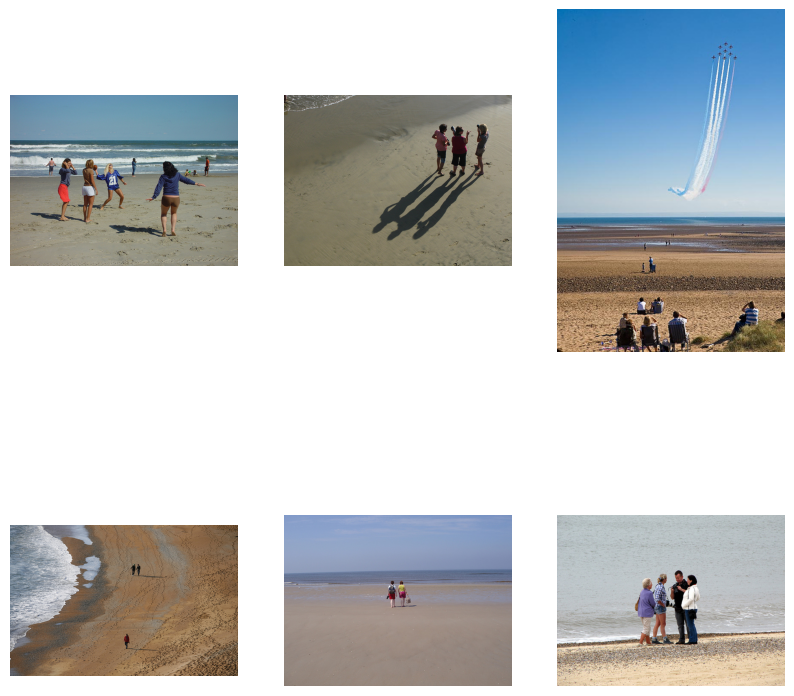

In [28]:
find_matches(
    clip_model,
    image_embeddings,
    query="people walking on the beach",
    tokenizer=tokenizer,
    image_filenames=val_df["image"].values,
    n=6,
)